In [1]:
import os
import json
import time
import gzip
import bcolz
import numpy as np
import re
import copy
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pickle
import random
import json

In [2]:
# variables
# seed = 1337
# pickleFile = '../Datasets/Reviews/dataset.pkl'
# gloveDimension = 50
# glovePath = "/media/data/Datasets/glove"
# dataset_reduction = 16
# trainPortion = 0.80
# vocabularyLimit = 30000
# cutoff = 60
# datasetFile = '../Datasets/Reviews/dataset_ready.pkl'
# example_item_id = 19

params = {
    "seed" : 1337,
    "pickleFile" :  '../Datasets/Reviews/dataset.pkl',
    "gloveDimension" : 50,
    "glovePath" : "/media/data/Datasets/glove",
    "datasetReduction" : 16,
    "trainPortion" : 0.80,
    "vocabularyLimit" : 30000,
    "cutoff" : 60,
    "datasetFile" : '../Datasets/Reviews/dataset_ready.pkl',
    "example_item_id" : 19, 
}

In [3]:
random.seed(params['seed'])
np.random.seed(params['seed'])

from spacy.lang.en import English
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

## Loading the Dataset

In [4]:
start = time.clock()
dataset = pickle.load( open( params['pickleFile'], "rb" ))
duration = time.clock() - start
print("Loaded the dataset in", round(duration,2), "seconds.")

Loaded the dataset in 8.81 seconds.


In [5]:
print("There are",len(dataset), "amazon items.")

There are 63001 amazon items.


## Loading Glove Words

In [6]:
def loadGlove(glove_path, dim=50):
    acceptedDimensions = [50, 100, 200, 300]
    if dim not in acceptedDimensions:
        print("You didn't choose a right dimension.")
        print("Try one of these:", acceptedDimensions)
        return None
    pickleWordFile = f'{glove_path}/6B.'+str(dim)+'_words.pkl'
    pickleIdFile   = f'{glove_path}/6B.'+str(dim)+'_idx.pkl'
    pickleDatFile  = f'{glove_path}/glove.6B.'+str(dim)+'.dat'
    pickleDataset  = f'{glove_path}/glove.6B.'+str(dim)+'d.txt'
    
    if os.path.isfile(pickleWordFile):
        # check if we've made the outputs before
        print("Preloading files..", end=" ")
        vectors = bcolz.open(pickleDatFile)[:]
        words = pickle.load(open(pickleWordFile, 'rb'))
        word2idx = pickle.load(open(pickleIdFile, 'rb'))
        glove = {w: vectors[word2idx[w]] for w in words}
        print("Done.")
        return glove
    else:
        print("Doesn't work.", end=" ")

glove = loadGlove(params['glovePath'], dim=params['gloveDimension'])
gloveWords = glove.keys()

Preloading files.. Done.


In [7]:
print("Glove Vocabulary Size:",len(gloveWords))

Glove Vocabulary Size: 400000


## Preprocessing Data

In [8]:
def preprocess(paragraph):
    # split paragraph by full stops
    paragraph = paragraph.lower()
    paragraph = re.sub("([,!?()-+&£$.%*'])", r' \1 ', paragraph)
    paragraph = re.sub('\s{2,}', ' ', paragraph)
    paragraph = paragraph.split(" ")
    # remove empty string
    return paragraph
    
def discretise(value, word):
    return word + "_" + str(value)

In [9]:
def handleItem(itemID, dataset=dataset, printDebug=False):
    """
    Filters words out based on whether they're in the GloVe dataset or not.
    
    Parameters:
    
    """

    reviews = []
    for i in range(len(dataset[itemID])):
        # initialise variables
        entry = dataset[itemID][i]
        reviewerID = entry['reviewerID']
        
        if len(entry['reviewText']) < 1:
            continue

        """
        Review Text Processing
        """

        # spacy method
        sentences = [list(filter(None, preprocess(str(sentence)))) for sentence in nlp(entry['reviewText']).sents]
            
        # preprocess summary
        summary = list(filter(None,preprocess(entry['summary'])))
        
        # merge summary sequence and review sequences together into overall entries.
        if len(sentences) < 2:
            entries =  [["<sos>", "<summary>"] + summary + ["</summary>"]] + [["<sos>", "<text>"] + sentences[0] + ["</text>", "<eor>", "<eos>"]]
        else:
            subset = [["<sos>", "<text>"] + x + ["</text>"] for x in sentences[:-1]]
            entries =  [["<sos>", "<summary>"] + summary + ["</summary>"]] + subset + [["<sos>", "<text>"] + sentences[-1] + ["</text>", "<eor>", "<eos>"]]

        # setup review parameters
        rating   = [discretise(entry['overall'], "rating")]

        # compute polarity
        good, bad = entry['helpful'][0], entry['helpful'][1]
        
        try:
            polarity = (good - bad) / (good + bad)
        except ZeroDivisionError:
            polarity = 0
        polarity = np.tanh(polarity)
        polarity = np.round(polarity, 1)
        polarity = [discretise(polarity, "polarity")]

        # create identity/conditioning entry
        identifier = itemID.lower()
        identity = [l for l in identifier] + rating + polarity

        # add conditionining entry to each entry
        formatted = [entry for entry in entries]

        if printDebug:
            print("ENTRY:",dataset[itemID][i])
            print("IDENTITY:",identity)

        for i in range(len(formatted)-1):
            # add the conditioning variable to the input. the output value does not have the conditioning variable.
            reviews.append([identity + formatted[i], formatted[i+1]])
            if printDebug:
                print(reviews[-1][0], "->", reviews[-1][1])
        if printDebug:
            break
            
    return reviews

In [10]:
datasetKeys = list(dataset.keys())
example_set = handleItem(datasetKeys[params['example_item_id']],printDebug=True)

ENTRY: {'reviewerID': 'AA8JH8LD2H4P9', 'asin': '7214047977', 'reviewerName': 'Claudia J. Frier', 'helpful': [3, 4], 'reviewText': 'This fits my 7" kindle fire hd perfectly! I love it. It even has a slot for a stylus. The kindle is velcroed in so it\'s nice and secure. Very glad I bought this!', 'overall': 5.0, 'summary': 'love it', 'unixReviewTime': 1354665600, 'reviewTime': '12 5, 2012'}
IDENTITY: ['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', '<sos>', '<summary>', 'love', 'it', '</summary>'] -> ['<sos>', '<text>', 'this', 'fits', 'my', '7"', 'kindle', 'fire', 'hd', 'perfectly', '!', '</text>']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_-0.1', '<sos>', '<text>', 'this', 'fits', 'my', '7"', 'kindle', 'fire', 'hd', 'perfectly', '!', '</text>'] -> ['<sos>', '<text>', 'i', 'love', 'it', '.', '</text>']
['7', '2', '1', '4', '0', '4', '7', '9',

In [11]:

identity = example_set[0][0][:example_set[0][0].index("<sos>")]

example_tag = {"reference":dataset[datasetKeys[params['example_item_id']]][0],
               "result":example_set}
print(json.dumps(example_tag, indent=2, sort_keys=True))

{
  "reference": {
    "asin": "7214047977",
    "helpful": [
      3,
      4
    ],
    "overall": 5.0,
    "reviewText": "This fits my 7\" kindle fire hd perfectly! I love it. It even has a slot for a stylus. The kindle is velcroed in so it's nice and secure. Very glad I bought this!",
    "reviewTime": "12 5, 2012",
    "reviewerID": "AA8JH8LD2H4P9",
    "reviewerName": "Claudia J. Frier",
    "summary": "love it",
    "unixReviewTime": 1354665600
  },
  "result": [
    [
      [
        "7",
        "2",
        "1",
        "4",
        "0",
        "4",
        "7",
        "9",
        "7",
        "7",
        "rating_5.0",
        "polarity_-0.1",
        "<sos>",
        "<summary>",
        "love",
        "it",
        "</summary>"
      ],
      [
        "<sos>",
        "<text>",
        "this",
        "fits",
        "my",
        "7\"",
        "kindle",
        "fire",
        "hd",
        "perfectly",
        "!",
        "</text>"
      ]
    ],
    [
      [
   

In [12]:
print(len(datasetKeys))

63001


In [13]:
def processItems(func, args, n_processes = 7):
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in enumerate(p.imap_unordered(func, args)):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

In [14]:
reviews = processItems(handleItem,datasetKeys[::params['datasetReduction']])

100%|██████████| 3938/3938 [00:32<00:00, 122.34it/s]


In [15]:
datasetSize = len(reviews)
trainRatio = int(datasetSize * params['trainPortion'])

train = reviews[:trainRatio]
validation = reviews[trainRatio:]

print("Num Reviews:")
print("Training:", len(train), "\t\tValidation:",len(validation))

# now we need to flatten train and validation.
trainents = []
for review in train:
    trainents += [entry for entry in review]
valents = []
for review in validation:
    valents += [entry for entry in review]
    
train = trainents
validation = valents

print("Sequences:")
print("Training:",len(train),"\tValidation:",len(validation))

Num Reviews:
Training: 3150 		Validation: 788
Sequences:
Training: 582471 	Validation: 145102


In [16]:
# get the number of itemIDs
for row in train:
    print(row)
    break

[['b', '0', '0', '0', '0', '0', 'j', '1', 'u', 'b', 'rating_5.0', 'polarity_0.0', '<sos>', '<summary>', 'kb', 'at', 'to', 'ps/2', 'adapter', '</summary>'], ['<sos>', '<text>', 'the', 'package', 'arrived', 'in', 'a', 'timely', 'fashion', 'and', 'in', 'good', 'shape', '.', '</text>']]


## Getting ID's of words

To improve the throughput of the model, we should reduce the embedding size. Here we'll look at all the words and keep track ones that exist. We'll make a reduced word2id based on this set.

In [17]:
wordcounts = {}

In [18]:
# here we reduce the size of the dataset so we can debug our model.
print("Subsetting Reviews..")
print("We now have", len(train), "reviews.")

Subsetting Reviews..
We now have 582471 reviews.


In [19]:
# get word frequency for words in training data
for row in tqdm(train):
    for sequences in row:
        for word in sequences:
            word = str(word)
            if word not in wordcounts:
                wordcounts[word] = 0
            wordcounts[word] += 1

100%|██████████| 582471/582471 [00:10<00:00, 54668.35it/s]


In [20]:
# get words that are not in the glove dataset
knowns   = [word for word in wordcounts if word in glove]
unknowns = [word for word in wordcounts if word not in glove]
# sort words by their frequency
wordOrder = list(sorted(knowns, key=lambda x: wordcounts[x], reverse=True))

In [21]:
print(len(knowns), len(unknowns))

43000 96066


In [22]:
wordOrder = wordOrder[:params['vocabularyLimit']]

In [23]:
weights = [glove[word] for word in wordOrder]

In [24]:
for word in unknowns:
    if ("rating" in word) or ("polarity" in word):
        try:
            part = word.split("_")
            if part[1] == "-0.0":
                part[1] = "0.0"
            weight = glove[part[0]] + glove[part[1]]
            wordOrder.append(word)
            weights.append(weight)
        except:
            pass

In [25]:
# create dictionaries for constant time referencing
id2word = {idx: w for (idx, w) in enumerate(wordOrder)}
word2id = {w: idx for (idx, w) in enumerate(wordOrder)}

In [26]:
lim = len(word2id)

# add <sos> (start of sequence)
weights.append(glove['sos'])
word2id['<sos>'] = lim
id2word[lim] = ['<sos>']
lim += 1

# add <eos> (end of sequence)
weights.append(glove['eos'])
word2id['<eos>'] = lim
id2word[lim] = '<eos>'
lim += 1


gloveDimension = params['gloveDimension']

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<summary>'] = lim
id2word[lim] = '<summary>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['</summary>'] = lim
id2word[lim] = '</summary>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<text>'] = lim
id2word[lim] = '<text>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['</text>'] = lim
id2word[lim] = '</text>'
lim += 1


# add <unk> (unknown token)
weights.append(glove['unk'])
word2id['<unk>'] = lim
id2word[lim] = '<unk>'

# add <pad> 
id2word[len(word2id)] = "<pad>"
word2id["<pad>"] = len(word2id)
weights.append(np.random.normal(0,0,gloveDimension))

In [27]:
np.random.normal(0,0,gloveDimension)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
def wordToID(word,corp=word2id):
    if word in corp:
        return corp[word]
    return corp['<unk>']

def IDToWord(id,corp=id2word, ref=word2id):
    if id in corp:
        return corp[id]
    return corp[ref['<unk>']]

In [29]:
# convert words to their id's in the review.
def entriesToWordIDs(group):
    return [[[wordToID(word) for word in seq] for seq in row] for row in tqdm(group)]
    
train = entriesToWordIDs(train)
validation = entriesToWordIDs(validation)

100%|██████████| 145102/145102 [00:01<00:00, 93946.82it/s]


In [30]:
sizes = {}
for i in range(len(train)):
    row = train[i]
    for seq in row:
        length = len(seq)
        if length not in sizes:
            sizes[length] = []
        sizes[length].append(i)

seqlengths = list(sorted(sizes.keys(), key=lambda x: len(sizes[x]), reverse=True))
print("The longest sequence in our dataset is",max(seqlengths),"tokens long.")

The longest sequence in our dataset is 7141 tokens long.


In [31]:
" ".join([IDToWord(x) for x in train[sizes[max(seqlengths)][0]][1][1:]])

'<text> they are listed in order of most inputs first , and more powerful amps first . . . * * * * * * * * * * * * * * * * * * * <unk> <unk> power , 2 channels <unk> , 1 khz @ 1 % thd . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <unk> , 1 khz @ 10 % thd . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <unk> power . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <unk> , <unk> @ 1 % thd . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <unk> harmonic distortion @ 1 khz rated power . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0 . 3 % input sensitivity @ 1 khz , <unk> rated <unk> 1 , aux 2 , cd , usb . . . . . 

In [32]:
# used for charting purposes
for i in range(1709):
    if i not in sizes:
        sizes[i] = []

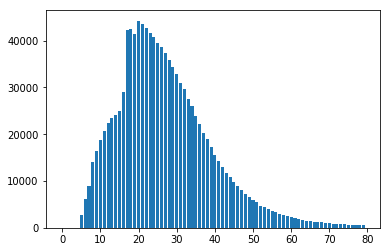

In [33]:
# plot histogram of sequence lengths
ents = [x for x in range(0,80)]
bins = [len(sizes[x]) for x in ents]
plt.bar(ents,bins)
plt.show()

In [34]:
print("Cutoff sequence length:", params['cutoff'])

Cutoff sequence length: 60


In [35]:
def trimSeq(group, cutoff):
    good = []
    for i in tqdm(range(len(group))):
        row = group[i]
        if len(row[0]) <= cutoff and len(row[1]) <= cutoff:
            good.append(i) 
    group = [group[x] for x in good]
    return group

#     return [[seq[:cutoff] for seq in row] for row in tqdm(group)]

print("BEFORE:", len(train), len(validation))
train = trimSeq(train, params['cutoff'])
validation = trimSeq(validation, params['cutoff'])
print("AFTER:", len(train), len(validation))

 44%|████▎     | 253808/582471 [00:00<00:00, 2538076.37it/s]

BEFORE: 582471 145102


100%|██████████| 145102/145102 [00:00<00:00, 2608319.94it/s]

AFTER: 553872 136909


In [36]:
# create container ready for use in dataset
# we do not add padding here as we want to reduce storage size!
container = {
    'id2word' : id2word,
    'word2id' : word2id,
    'train' : train,
    'validation': validation,
    'weights' : np.matrix(weights),
    'cutoff' : params['cutoff']
}

In [37]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0
        
# save the dataset to a pickle file.
output = open(params['datasetFile'], 'wb')
pickle.dump(container, output)
output.close()

# save dataset preprocessing parameters
params['example_filtering'] = example_tag
param_jsonpath = 'dataset_parameters.json'
with open(param_jsonpath, 'w') as outfile:
    json.dump(params, outfile)
    
print("Saved!", convert_bytes(os.stat(params['datasetFile']).st_size))

Saved! 110.1 MB


In [39]:
import torch

In [40]:
# get sequence lengths for train and validation data
trainx = [x[0] for x in train]
trainy = [x[1] for x in train]
valx   = [x[0] for x in validation]
valy   = [x[1] for x in validation]

In [43]:
from vad_utils import batchData

device = "cpu"
batchsize = 32
trainx_p = batchData(trainx, word2id['<pad>'], device, batchsize, params['cutoff'])
trainy_p = batchData(trainy, word2id['<pad>'], device, batchsize, params['cutoff'])
valx_p = batchData(valx, word2id['<pad>'], device, batchsize, params['cutoff'])
valy_p = batchData(valy, word2id['<pad>'], device, batchsize, params['cutoff'])

train_p = (trainx_p, trainy_p)
val_p = (valx_p, valy_p)

In [ ]:
weightshape = np.matrix(weights).shape
weightshape

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
for batch in range(len(train_p[0])):
    # load x, y from batch
    entry_x, entry_y = train_p[0][batch], train_p[1][batch]
    # sepeate data from sentence lengths
    y_outs, y_seqs = entry_y
    
    # get y_length
    y_len = len(y_outs[0])
    
    num_classes = weightshape[0]
    batch_size = y_outs.shape[0]
    
    loss = nn.BCEWithLogitsLoss()
    sig =nn.Sigmoid()
    
    # iterate through the words in y
    for w in range(y_len):
        # get indexes of future words
        labels = y_outs[:,w:].long().unsqueeze(2)
        print("LABELS:",labels.shape)
        print("Y:", y_outs[:,w:].shape)
        
        print(labels[0].unique())
        
        
        bug = torch.FloatTensor(batch_size, num_classes).zero_()
        bug.scatter_(1, y_outs[:,w:], 1)
        print("BUG:", bug.shape)

        print("YES:",(bug[0] > 0).max())
#         print(labels)
        # set up bag of words container
        bow = torch.FloatTensor(batch_size, y_len-w, num_classes).zero_()
        print("BOW BASE:", bow.shape)
        # create SBOW
        bow.scatter_(2, labels, 1)
        # sum by dimension and limit values between 0 and 1
        bow = torch.sum(bow, dim=1).clamp(0,1)
#         print(bow[0])
        print(bow[0])
        print("BOW:",bow.shape)
              
        print("SAME?:",torch.all(bug.eq(bow)).item() == 1)
        
        
        # generate some random matrix of the same shape
        guess = torch.rand(batch_size, num_classes)
        guess = sig(guess)
        err = loss(guess,bug)
        print(err)
        err = loss(guess,bow)
        print(err)
        print()
        break
    break